In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, DBSCAN, MiniBatchKMeans, MeanShift, SpectralClustering, KMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

from get_nice_text import *

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

Do feature engineering spróbowaliśmy następujących podejść:
 * stop_words - usunięcie z kolumn słów pokroju "the", "and" itp.
 * entities - encja, reprezentująca @TODO nie wiem jak to ładnie opisać
 * słownika nlp - biblioteka, która zawiera własny słownik, wyodrębniający słowa z tekstu
 * TfidfTransformer - skaluje wystąpienia biorąc pod uwagę wystąpienia w całym tekście, by uwzględnić wagę i częstotliwość danego słowa
 * lematyzacja - sprowadzanie słów do ich podstawowego słowa, np. kotek -> kot, mierzyła -> miara
 * stemming - usuwanie końcówek fleksyjnych
 * usuwanie kolumn o niskiej wariancji
 * redukcja wymiarów przy pomocy tsne i pca

Część metod nie polepszyła wyników, a niektóre nawet znacznie je obniżyła. Ostatecznie zdecydowaliśmy się na wykorzystanie stop-words z angielskiego słownika oraz TfidfTransformer z sklearn.

## Przykładowy model

In [13]:
def train_fast(df, Model, labels, **kwargs):
    """
    Trenuje Model na sparse matrix df
    @example
    train fast(df, KMeans, n_clusters=8)
    """
    trans = TfidfTransformer()
    df_trans = trans.fit_transform(df)
    model = Model(**kwargs)
    lab = model.fit_predict(df_trans)
    
    ret = {}
    
    ret["homogeneity_score"] = homogeneity_score(labels, lab)
    ret["completeness_score"] = completeness_score(labels, lab)
    ret["v_measure_score"] = v_measure_score(labels, lab)
    

    return lab, ret, model

In [9]:
df = get_nice_text()
np.random.seed(123)

cv = CountVectorizer()
df_count = cv.fit_transform(df)

lab, scores, m = train_fast(df_count, KMeans, get_labels(True), n_clusters=5, random_state = 123)
scores

{'homogeneity_score': 0.5504130721916395,
 'completeness_score': 0.5575716186373115,
 'v_measure_score': 0.5539692201909778}

## Przetestowane modele

 * KMeans
 * MiniBatchKMeans
 * DBSCAN
 * Birch
 * AgglomerativeClustering
 * SpectralClustering
 * GaussianMixture
 
 Do testowania wyników modeli użyliśmy specjanie stworzonej przez nas funkcji fast_GridSearch, która umożliwia nam przetestowanie wielu różnych modeli z różnymi parametrami.

Użyte metryki: @TODO opisy
 * homogeneity_score
 * completeness_score
 * v_measure_score - średnia harmoniczna z dwóch powyższych
 * silhouette_score
 

In [6]:
def train_fast(df, model, labels):
    """
    Changed train_fast, now takes model as initiated object


    Trenuje Model na sparse matrix df
    @example
    train fast(df, KMeans, n_clusters=8)
    """
    trans = TfidfTransformer()
    df_trans = trans.fit_transform(df)
    lab = model.fit_predict(df_trans.toarray())

    ret = {}

    ret["homogeneity_score"] = homogeneity_score(labels, lab)
    ret["completeness_score"] = completeness_score(labels, lab)
    ret["v_measure_score"] = v_measure_score(labels, lab)
    ret["silhouette_score"] = silhouette_score(df, lab)

    return lab, ret

In [7]:
results_table = pd.DataFrame(columns=[
                             "name", "homogeneity_score", "completeness_score", "v_measure_score", "silhouette_score"])


def fast_GridSearch(method, parameter_dict, df, labels, name_of_method, results_table, **kwargs):
    """
    Parameters
    ============================================================
    Method: 
        initiated method object

    perameter_dict: 
        dictionary containing name of parameters as keys and as values list of values to check. Number of keys should be 2. 

    df:
        DataFrame with data

    labels: 
        labels array

    name_of_method: 
        string, name of method

    results_table: 
        results table is meant to be dataframe where results will be added

    Return
    ===============================================================

    Output: 
        DataFrame
    """

    keys = list(parameter_dict.keys())
    assert(len(keys) == 2)

    results = pd.DataFrame(columns=["name", "param1", "param2", "homogeneity_score",
                                    "completeness_score", "v_measure_score", "silhouette_score"])

    bound = len(parameter_dict.get(keys[0])) * len(parameter_dict.get(keys[1]))
    i = 1

    print(f'Starting {name_of_method}')

    for par1 in parameter_dict.get(keys[0]):
        for par2 in parameter_dict.get(keys[1]):

            try:
                sys.stdout.write('\r')
                print(f'progres: {i}/{bound}', end='')

                tmp_params = {keys[0]: par1,
                              keys[1]: par2}

                # setting additional parameters
                met = method(**tmp_params, **kwargs)
                _, ret = train_fast(df, met, labels)

                row = {"name": [name_of_method],
                       "param1": [par1],
                       "param2": [par2],
                       "homogeneity_score": [ret.get("homogeneity_score")],
                       "completeness_score": [ret.get("completeness_score")],
                       "v_measure_score": [ret.get("v_measure_score")],
                       "silhouette_score": [ret.get("silhouette_score")]}

                row = pd.DataFrame(data=row)
                results_table = pd.concat([results_table, row])

            except:
                pass
            i += 1

            results_table = results_table.reset_index(drop=True)

    print(f'\nEnded {name_of_method}')
    return results_table

In [8]:
% % time

results_table = pd.DataFrame(columns=[
                             "name", "param1", "param2", "homogeneity_score", "completeness_score", "v_measure_score"])


spec_d = {'degree': [1, 2, 3, 4, 5],
          'gamma': [0.5, 0.8, 1, 1.3, 1.6]}

results_table = fast_GridSearch(SpectralClustering,
                                spec_d,
                                df_count,
                                get_labels(True),
                                "SpectralClustering",
                                results_table,
                                random_state=42,
                                n_init=20)


kmeans_d = {'init': ['k-means++', 'random'],
            'n_init': [20]}  # not many to tune

results_table = fast_GridSearch(KMeans,
                                kmeans_d,
                                df_count,
                                get_labels(True),
                                "KMeans",
                                results_table,
                                random_state=42,
                                n_clusters=5)

agg_d = {'affinity': ["euclidean", "l1", "l2", "manhattan", "cosine"],
         'linkage': ["ward", "complete", "average", "single"]}

results_table = fast_GridSearch(AgglomerativeClustering,
                                agg_d,
                                df_count,
                                get_labels(True),
                                "AgglomerativeClustering",
                                results_table,
                                n_clusters=5)

mbkmeans_d = {'init': ['k-means++', 'random'],
              'reassignment_ratio': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]}

results_table = fast_GridSearch(MiniBatchKMeans,
                                mbkmeans_d,
                                df_count,
                                get_labels(True),
                                "MiniBatchKMeans",
                                results_table,
                                random_state=42,
                                n_clusters=5)

gaussm_d = {'covariance_type': ['full', 'tied', 'diag', 'spherical'],
            'warm_start': [True, False]}

results_table = fast_GridSearch(GaussianMixture,
                                gaussm_d,
                                df_count,
                                get_labels(True),
                                "GaussianMixture",
                                results_table,
                                random_state=42,
                                n_components=5)

birch_d = {'threshold': list(np.arange(0.1, 1, 0.1)),
           'branching_factor': list(np.arange(10, 100, 20))}

results_table = fast_GridSearch(Birch,
                                birch_d,
                                df_count,
                                get_labels(True),
                                "Birch",
                                results_table,
                                n_clusters=5)


results_table5 = results_table
results_table5

Starting SpectralClustering
progres: 25/25
Ended SpectralClustering
Starting KMeans
progres: 2/2
Ended KMeans
Starting AgglomerativeClustering
progres: 20/20
Ended AgglomerativeClustering
Starting MiniBatchKMeans
progres: 14/14
Ended MiniBatchKMeans
Starting GaussianMixture
progres: 8/8
Ended GaussianMixture
Starting Birch
progres: 45/45
Ended Birch
CPU times: user 32min 16s, sys: 2min 1s, total: 34min 18s
Wall time: 19min 32s


,name,param1,param2,homogeneity_score,completeness_score,v_measure_score,silhouette_score
0,SpectralClustering,1,0.5,0.517659,0.440622,0.476044,-0.155346
1,SpectralClustering,1,0.8,0.523090,0.444914,0.480845,-0.158885
2,SpectralClustering,1,1,0.522113,0.469818,0.494587,-0.159588
3,SpectralClustering,1,1.3,0.505981,0.472994,0.488932,-0.212562
4,SpectralClustering,1,1.6,0.497955,0.474987,0.486200,-0.213314
...,...,...,...,...,...,...,...
102,Birch,0.9,10,0.286299,0.443002,0.347816,-0.213166
103,Birch,0.9,30,0.263286,0.485398,0.341395,-0.289430
104,Birch,0.9,50,0.283962,0.435420,0.343747,-0.189677
105,Birch,0.9,70,0.354038,0.475926,0.406032,-0.178280


In [9]:
%%time

results_table = pd.DataFrame(columns= ["name","homogeneity_score","completeness_score","v_measure_score"])


spec_d = {'degree': [1, 2, 3, 4, 5],
          'gamma': [0.5, 0.8, 1, 1.3, 1.6]}

results_table = fast_GridSearch(SpectralClustering,
                                spec_d, df_count,
                                get_labels(False),
                                "SpectralClustering",
                                results_table,
                                random_state = 42,
                                n_init = 20,
                               n_clusters = 8)


kmeans_d = {'init'  : ['k-means++', 'random'], 
            'n_init': [20]} # not many to tune

results_table = fast_GridSearch(KMeans,
                                kmeans_d,
                                df_count,
                                get_labels(False),
                                "KMeans",
                                results_table, 
                                random_state = 42,
                                n_clusters = 8)

agg_d = {'affinity' : ["euclidean", "l1", "l2", "manhattan", "cosine"],
         'linkage'  : ["ward", "complete", "average", "single"]}

results_table = fast_GridSearch(AgglomerativeClustering,
                                agg_d,
                                df_count,
                                get_labels(False),
                                "AgglomerativeClustering",
                                results_table,
                                n_clusters = 8)

mbkmeans_d = {'init'  : ['k-means++', 'random'], 
            'reassignment_ratio': [0.001, 0.005,0.01,0.05,0.1,0.2,0.3] } 

results_table = fast_GridSearch(MiniBatchKMeans,
                                mbkmeans_d,
                                df_count,
                                get_labels(False),
                                "MiniBatchKMeans",
                                results_table,
                                random_state = 42,
                                n_clusters = 8)

gaussm_d = {'covariance_type' : ['full', 'tied', 'diag', 'spherical'], 
            'warm_start'      : [True, False]}

results_table = fast_GridSearch(GaussianMixture,
                                gaussm_d,
                                df_count,
                                get_labels(False),
                                "GaussianMixture", 
                                results_table, 
                                random_state = 42,
                                n_components = 8)

birch_d = {'threshold': list(np.arange(0.1,1,0.1)),
          'branching_factor': list(np.arange(10,100,20))}

results_table = fast_GridSearch(Birch,
                                birch_d,
                                df_count,
                                get_labels(False),
                                "Birch", 
                                results_table,
                                n_clusters = 8)


results_table8 = results_table
results_table8

Starting SpectralClustering
progres: 25/25
Ended SpectralClustering
Starting KMeans
progres: 2/2
Ended KMeans
Starting AgglomerativeClustering
progres: 20/20
Ended AgglomerativeClustering
Starting MiniBatchKMeans
progres: 14/14
Ended MiniBatchKMeans
Starting GaussianMixture
progres: 8/8
Ended GaussianMixture
Starting Birch
progres: 45/45
Ended Birch
CPU times: user 20min 32s, sys: 34.4 s, total: 21min 6s
Wall time: 12min 4s


,name,homogeneity_score,completeness_score,v_measure_score,param1,param2,silhouette_score
0,SpectralClustering,0.464996,0.458428,0.461689,1,0.5,-0.155346
1,SpectralClustering,0.471206,0.464204,0.467679,1,0.8,-0.158885
2,SpectralClustering,0.470806,0.490689,0.480542,1,1,-0.159588
3,SpectralClustering,0.458038,0.495933,0.476233,1,1.3,-0.212562
4,SpectralClustering,0.451108,0.498394,0.473574,1,1.6,-0.213314
...,...,...,...,...,...,...,...
100,Birch,0.275030,0.388134,0.321937,0.9,10,-0.221844
101,Birch,0.275898,0.385757,0.321707,0.9,30,-0.275047
102,Birch,0.306868,0.386702,0.342190,0.9,50,-0.193569
103,Birch,0.331440,0.373396,0.351169,0.9,70,-0.164636


In [5]:
results_table5["clusters"] = 5
results_table8["clusters"] = 8
results_table = pd.concat([results_table5, results_table8])
results_table.sort_values("v_measure_score", ascending=False)

,Unnamed: 0,name,param1,param2,homogeneity_score,completeness_score,v_measure_score,silhouette_score,clusters
26,26,KMeans,random,20.0,0.609115,0.622554,0.615761,-0.159806,5
92,92,Birch,0.7000000000000001,10,0.592939,0.610178,0.601435,-0.099444,5
100,100,Birch,0.8,70,0.559585,0.646295,0.599823,-0.162860,5
96,96,Birch,0.7000000000000001,90,0.556719,0.643486,0.596966,-0.166259,5
79,79,Birch,0.4,50,0.578265,0.610506,0.593949,-0.104312,5
...,...,...,...,...,...,...,...,...,...
33,33,AgglomerativeClustering,l1,single,0.007544,0.227242,0.014603,0.311063,5
30,30,AgglomerativeClustering,euclidean,single,0.007544,0.227242,0.014603,0.180825,5
36,36,AgglomerativeClustering,l2,single,0.007544,0.227242,0.014603,0.180825,5
38,38,AgglomerativeClustering,manhattan,average,0.007544,0.227242,0.014603,0.311063,5


Najlepiej radzącym sobie modelem w odwozorowaniu odpowiednich tekstów wypada KMeans z parametrami init = "random" i n_init = 20. Niewiele gorzej radzi sobie algorytm Birch z dowolnymi parametrami.

# Biblia czy księgi?
Na początku projektu postawiliśmny hipotezę, iż łączenie ksiąg bilblijnych w jedną klasę 'Biblia' sprawi, iż modele będą osiągały lepsze wyniki. Mając wytrenowane modele dla obu wariantów możemy porównać te wyniki i jasno potwierdzić lub obalić hipotezę.

Spójrzmy jednak najpierw na dobrze nam znany łokieć oraz silhouette_score dla najbardziej trywialnego algorytmu - KMeans:

In [17]:
np.random.seed(123)
l = []
s = []
for i in range(2,11):
    lab, ret, m = train_fast(df_count, KMeans, get_labels(True), random_state = 123, n_clusters = i)
    l.append(m.inertia_)
    s.append(silhouette_score(df_count, lab))

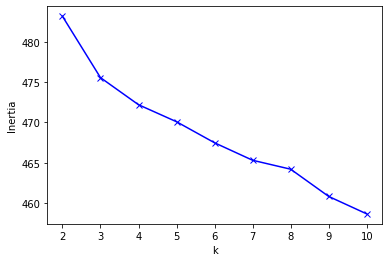

In [18]:
plt.plot(range(2,11), l, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

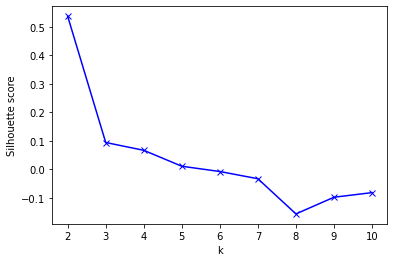

In [19]:
plt.plot(range(2,11), s, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Porównajmy teraz wyniki z naszych modeli:

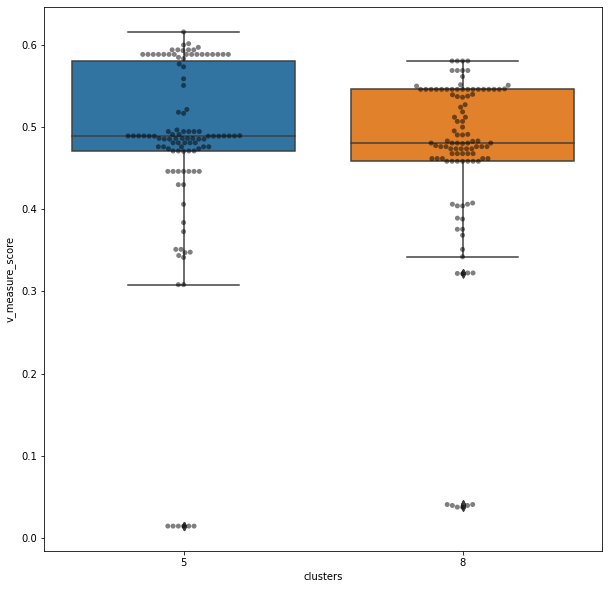

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
sns.boxplot(data = results_table, x = "clusters", y = "v_measure_score")
sns.swarmplot(data = results_table, x = "clusters", y = "v_measure_score", color = "black", alpha = 0.5)

Jak widać boxplot wyników dla ośmiu klastrów jest znaczenie bardziej zwięzły niż dla pięciu.

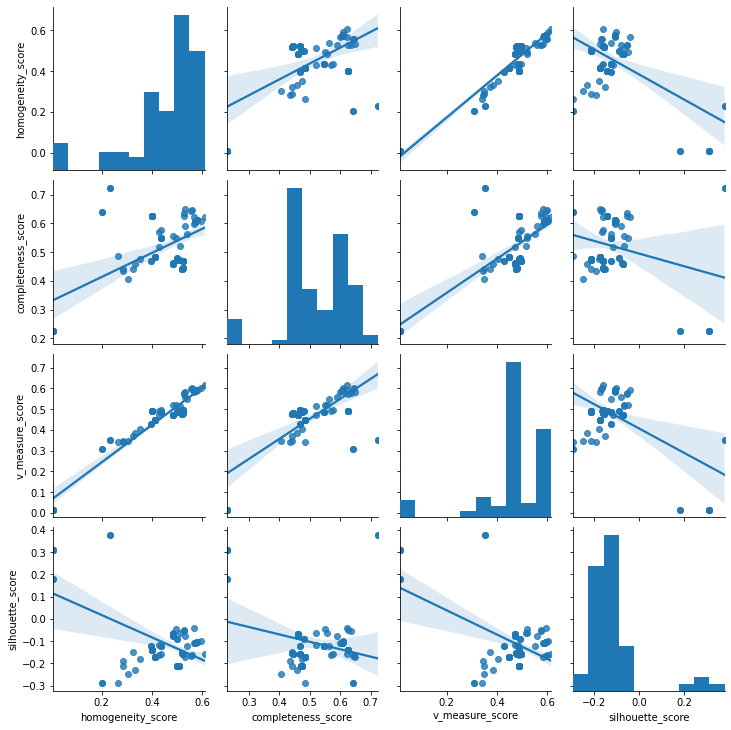

In [34]:
df = results_table5[["homogeneity_score","completeness_score","v_measure_score","silhouette_score"]]
sns.pairplot(df, kind = "reg", palette = "Set1")


In [41]:
df.corr()

,homogeneity_score,completeness_score,v_measure_score,silhouette_score
homogeneity_score,1.000000,0.570300,0.962013,-0.557255
completeness_score,0.570300,1.000000,0.756515,-0.271697
v_measure_score,0.962013,0.756515,1.000000,-0.567048
silhouette_score,-0.557255,-0.271697,-0.567048,1.000000


Można tu zauważyć pewną niepokojącą zależność - silhouette_score będące odwrotnie proporcjonalne do v_measure_score. Warto zaznaczyć, iż v_measure_score jest miarą tego, jak dobrze algorytm oznaczył labels w porównaniu do prawdziwych, natomiast silhouette_score jest miarą określającą jak dobrze punkt pasuje do klastra. Ujemna korelacja sugeruje, że dobre dopasowanie do klastrów i poprawne labels wzajemnie się wykluczają.

# Wnioski

* Najlepszymi modelami okazał się KMeans i Birch 
* Początkowa hipoteza, iż połączenie wszystkich księg Bibli i oznaczenie jej jako jednej klasy będzie wspomagało modele okazała się prawdziwa - po tuningu modeli najlepszy wyniki osiągnięte zostały do 5 klas.
* NLP jest rozległą i skomplikowaną dziedziną, której nie sposób "ot tak" zaimplementować. Trzeba przyłożyć do niej dużo uwagi i wiedzy, by móc w niej działać.

# Oświadczenie o samodzielności

Oświadczamy, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia
się z przedmiotu Wstęp do Uczenia Maszynowego, została wykonana przez nas samodzielnie.

Hanna Zdulska, Jakub Wiśniewski